In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'grid'])
matplotlib.rcParams["font.size"] = "12"

import torch
import torch.nn as nn
from torch.autograd import grad

from scipy.integrate import solve_ivp

In [2]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_layers, hidden_dim, input_dim=1, output_dim=1, init_rule=torch.nn.init.uniform_):
        super(FeedForwardNetwork, self).__init__()
        
        self.L = hidden_layers
        self.W = hidden_dim
        
        self.model = nn.Sequential()
        self.activation = nn.Tanh()
        
        inp_linear = nn.Linear(input_dim, hidden_dim)
        init_rule(inp_linear.weight)
        out_linear = nn.Linear(hidden_dim, output_dim)
        init_rule(out_linear.weight)
        
        self.model.add_module('input', inp_linear)
        self.model.add_module('activ0', self.activation)
        for i in range(hidden_layers - 1):
            linear = nn.Linear(hidden_dim, hidden_dim)
            init_rule(linear.weight)
            self.model.add_module(f'linear{i+1}', linear)
            self.model.add_module(f'activ{i+1}', self.activation)
        self.model.add_module('output', out_linear)
        
    def forward(self, x):
        return self.model(x)
    
    def weights_norm(self):
        S = 0
        with torch.no_grad():
            for name, parameter in self.model.named_parameters():
                # print(name, torch.linalg.norm(parameter))
                S += torch.linalg.norm(parameter)
        return S.item() / self.L

In [3]:
def plot(
    t, predictions, numerical, title, path, figsize=(5, 5), 
    show=True, save=False, dpi=300
    ):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(t, predictions[0], label=r'$\mathcal{X}(t)$')
    plt.plot(t, predictions[1], label=r'$\mathcal{Y}(t)$')
    plt.plot(t, numerical[0], label=r'$x(t)$')
    plt.plot(t, numerical[1], label=r'$y(t)$')
    
    plt.xlabel('t')
    plt.ylabel('Population size')
    
    plt.legend()
    plt.title(title)
    
    if save:
        plt.savefig(f'./images/lotkavolterra/{path}/{title}.png', dpi=dpi)
    
    if show:
        plt.show()
    else:
        plt.close()
        
def rmse(predicts, target):
    return np.sqrt(np.square(predicts - target).mean())

---
# First Approach

In [4]:
class LotkaVolterra:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.alpha, self.beta, self.delta, self.gamma = params
        self.init_vals = torch.tensor(initial_conditions)

        self.numerical_solution = self._solve()
    
    def loss_initial(self, X, Y):
        zero = torch.tensor([0.], requires_grad=True)
        x = X(zero)
        y = Y(zero)
        return torch.mean(torch.square(torch.hstack([x, y]) - self.init_vals))
    
    def loss_physical(self, X, Y, t):
        x = X(t)
        y = Y(t)
        dX = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dY = grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        loss_dX = torch.mean(torch.square(dX - self.alpha * x + self.beta * x * y))
        loss_dY = torch.mean(torch.square(dY - self.delta * x * y + self.gamma * y))
        
        return loss_dX, loss_dY
    
    def _solve(self):
        def lotka_volterra(t, y, alpha, beta, delta, gamma):
            x, y = y
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

        solution = solve_ivp(lotka_volterra, 
                             (0, self.T),
                             self.init_vals, 
                             method='RK45',
                             args=(self.alpha, self.beta, self.delta, self.gamma), 
                             t_eval=np.linspace(0, self.T, 128))
        
        return solution.y

In [7]:
def train(
    problem,
    X, Y,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000, save_every=1000
):
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    
    t = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)
 
    optim_X = torch.optim.Adam(X.parameters(), lr=lr)
    optim_Y = torch.optim.Adam(Y.parameters(), lr=lr)
    
    losses, weights, errors = [], [], []
    
    for i in range(0, num_iters + 1):
        
        optim_X.zero_grad()
        optim_Y.zero_grad()
        
        L_I = problem.loss_initial(X, Y)
        L_X, L_Y = problem.loss_physical(X, Y, t)
    
        L = w1 * L_I + w2 * L_X + w3 * L_Y
        
        L.backward()
        optim_X.step()
        optim_Y.step()
        
        if i % print_every == 0:
            preds_X = X(test_points).flatten().detach().numpy()
            preds_Y = Y(test_points).flatten().detach().numpy()
            print(f'Iteration {i} --- {rmse(preds_X, problem.numerical_solution[0])}, {rmse(preds_Y, problem.numerical_solution[1])}')
        
        if i % collect_every == 0:
            preds_X = X(test_points).flatten().detach().numpy()
            preds_Y = Y(test_points).flatten().detach().numpy()
            
            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            weights.append(np.array([X.weights_norm(), Y.weights_norm()]))
            errors.append(np.array([
                rmse(preds_X, problem.numerical_solution[0]),
                rmse(preds_Y, problem.numerical_solution[1])
            ]))
            
        if i % save_every == 0:
            predictions = [
                X(test_points).flatten().detach().numpy(),
                Y(test_points).flatten().detach().numpy()
            ]
            plot(test_points, predictions, problem.numerical_solution, f'Iteration {i}', 
                 path='first approach', figsize=(6, 4), show=False, save=True)
    
    preds_X = X(test_points).flatten().detach().numpy()
    preds_Y = Y(test_points).flatten().detach().numpy()
    
    return np.array(losses), np.array(weights), np.array(errors)

In [8]:
X, Y = FeedForwardNetwork(1, 32), FeedForwardNetwork(1, 32)
problem = LotkaVolterra(25., (0.4, 0.1, 0.1, 0.6), [10., 5.])

w1, w2, w3 = 1, 2, 2
num_iters = 50000
N_D = 1024
lr = 1e-2
collect_every = 500

losses, weights, errors = train(
    problem,
    X, Y,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=5000, save_every=500
)

Iteration 0 --- 8.4909962653693, 9.384683645238477
Iteration 5000 --- 2.0360354176031663, 1.6814558934387809
Iteration 10000 --- 1.7962418509024671, 1.5107880881847944
Iteration 15000 --- 1.2600985058100598, 1.0660415899068434
Iteration 20000 --- 0.9170895425118504, 0.7631871259317793
Iteration 25000 --- 0.7744469248625067, 0.6497507841836576
Iteration 30000 --- 0.6542376014483808, 0.5266775700215008
Iteration 35000 --- 0.5741377682408133, 0.45668207000329836
Iteration 40000 --- 0.5285644606424001, 0.4181979986435458
Iteration 45000 --- 0.4865757395841999, 0.38614507036057394
Iteration 50000 --- 0.45032938706390385, 0.35984930700817136


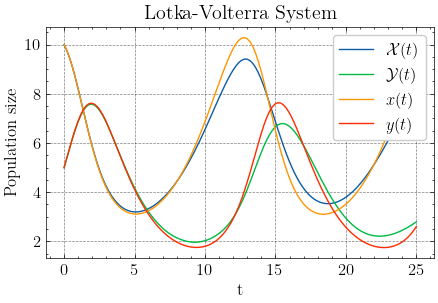

In [9]:
test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
predictions = [
    X(test_points).flatten().detach().numpy(),
    Y(test_points).flatten().detach().numpy()
]

plot(test_points, predictions, problem.numerical_solution, title='Lotka-Volterra System', figsize=(5, 3), save=True, path='first approach')

In [10]:
from PIL import Image

images = [Image.open(f'./images/lotkavolterra/first approach/Iteration {i}.png') for i in range(0, 50001, 500)]
images[0].save(fp="./images/lotkavolterra/first approach/learning.gif", format='GIF', append_images=images[1:], save_all=True, loop=0)

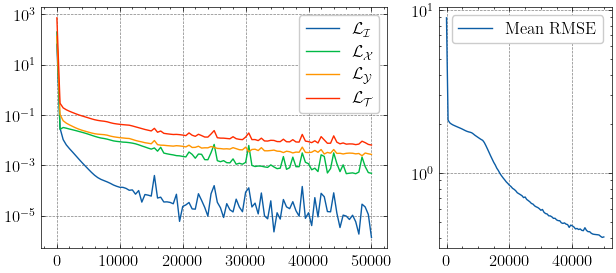

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={'width_ratios': [2, 1]})

t = np.arange(0, num_iters + 1, collect_every)

ax[0].plot(t, losses[:,0], label=r'$\mathcal{L_I}$')
ax[0].plot(t, losses[:,1], label=r'$\mathcal{L_X}$')
ax[0].plot(t, losses[:,2], label=r'$\mathcal{L_Y}$')
ax[0].plot(t, losses[:,3], label=r'$\mathcal{L_T}$')

ax[1].plot(t, errors.mean(axis=1), label='Mean RMSE')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# plt.grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()

plt.savefig('./images/lotkavolterra/first approach/Losses.png', dpi=300)

plt.show()

---
# Second Approach

In [4]:
class NewLotkaVolterra:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.alpha, self.beta, self.delta, self.gamma = params
        self.init_vals = torch.tensor(initial_conditions)

        self.numerical_solution = self._solve()
    
    def loss_initial(self, model):
        zero = torch.tensor([0.], requires_grad=True)
        x = model(zero)
        return torch.mean(torch.square(x - self.init_vals))
    
    def loss_physical(self, model, t):
        xy = model(t)
        x = xy[:,[0]]
        y = xy[:,[1]]

        dX = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dY = grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        loss_dX = torch.mean(torch.square(dX - self.alpha * x + self.beta * x * y))
        loss_dY = torch.mean(torch.square(dY - self.delta * x * y + self.gamma * y))
        
        return loss_dX, loss_dY
    
    def _solve(self):
        def lotka_volterra(t, y, alpha, beta, delta, gamma):
            x, y = y
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

        solution = solve_ivp(lotka_volterra, 
                             (0, self.T),
                             self.init_vals, 
                             method='RK45',
                             args=(self.alpha, self.beta, self.delta, self.gamma), 
                             t_eval=np.linspace(0, self.T, 128))
        
        return solution.y

In [5]:
def train_second(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000, save_every=1000
):
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    t = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, t)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if i % print_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            
            error_x = rmse(x, problem.numerical_solution[0])
            error_y = rmse(y, problem.numerical_solution[1])
            
            print(f'Iteration {i} --- {error_x}, {error_y}')
        
        if i % collect_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = rmse(x, problem.numerical_solution[0])
            error_y = rmse(y, problem.numerical_solution[1])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(np.array([error_x, error_y]))
            
        if i % save_every == 0:
            preds = model(test_points).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            plot(
                test_points, [x, y], problem.numerical_solution, f'Iteration {i}', path='second approach', figsize=(6, 4), show=False, save=True
            )
    
    return np.array(losses), np.array(errors)

In [18]:
model = FeedForwardNetwork(2, 64, input_dim=1, output_dim=2, init_rule=torch.nn.init.normal_)
problem = NewLotkaVolterra(25., (0.4, 0.1, 0.1, 0.6), [10., 5.])

w1, w2, w3 = 1, 2, 2
num_iters = 30000
N_D = 1024
lr = 1e-3
collect_every = 500

losses, errors = train_second(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=5000, save_every=500
)

Iteration 0 --- 2.8295768026743473, 4.37935838477211
Iteration 5000 --- 1.599913654157324, 1.3510541738709856
Iteration 10000 --- 0.7878837808592154, 0.6563948272692645
Iteration 15000 --- 0.3056089642869816, 0.2467714799099114
Iteration 20000 --- 0.1307002872802951, 0.10037879256795756
Iteration 25000 --- 0.0657250173434862, 0.05209052025481943
Iteration 30000 --- 0.041687719847589344, 0.034681027412403746


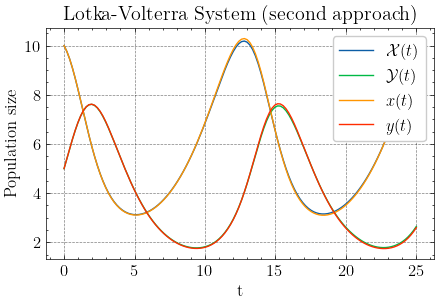

In [19]:
preds = model(test_points).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot(
    test_points, [x, y], problem.numerical_solution, title='Lotka-Volterra System (second approach)', figsize=(5, 3), save=True, path='second approach'
)

In [21]:
from PIL import Image

images = [Image.open(f'./images/lotkavolterra/second approach/Iteration {i}.png') for i in range(0, 30001, 500)]
images[0].save(fp="./images/lotkavolterra/second approach/learning.gif", format='GIF', append_images=images[1:], save_all=True, loop=0)

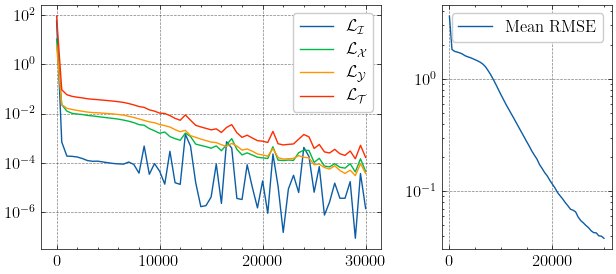

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={'width_ratios': [2, 1]})

t = np.arange(0, num_iters + 1, 500)

ax[0].plot(t, losses[:,0], label=r'$\mathcal{L_I}$')
ax[0].plot(t, losses[:,1], label=r'$\mathcal{L_X}$')
ax[0].plot(t, losses[:,2], label=r'$\mathcal{L_Y}$')
ax[0].plot(t, losses[:,3], label=r'$\mathcal{L_T}$')

ax[1].plot(t, errors.mean(axis=1), label='Mean RMSE')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# plt.grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()

plt.savefig('./images/lotkavolterra/second approach/Losses.png', dpi=300)

plt.show()

In [6]:
problem = NewLotkaVolterra(25., (0.4, 0.1, 0.1, 0.6), [10., 5.])
model = FeedForwardNetwork(2, 64, input_dim=1, output_dim=2, init_rule=torch.nn.init.normal_)

w1, w2, w3 = 1, 2, 2
t = torch.linspace(0, 25, 128, requires_grad=True).reshape(-1, 1)

L_I = problem.loss_initial(model)
L_X, L_Y = problem.loss_physical(model, t)

L = w1 * L_I + w2 * L_X + w3 * L_Y

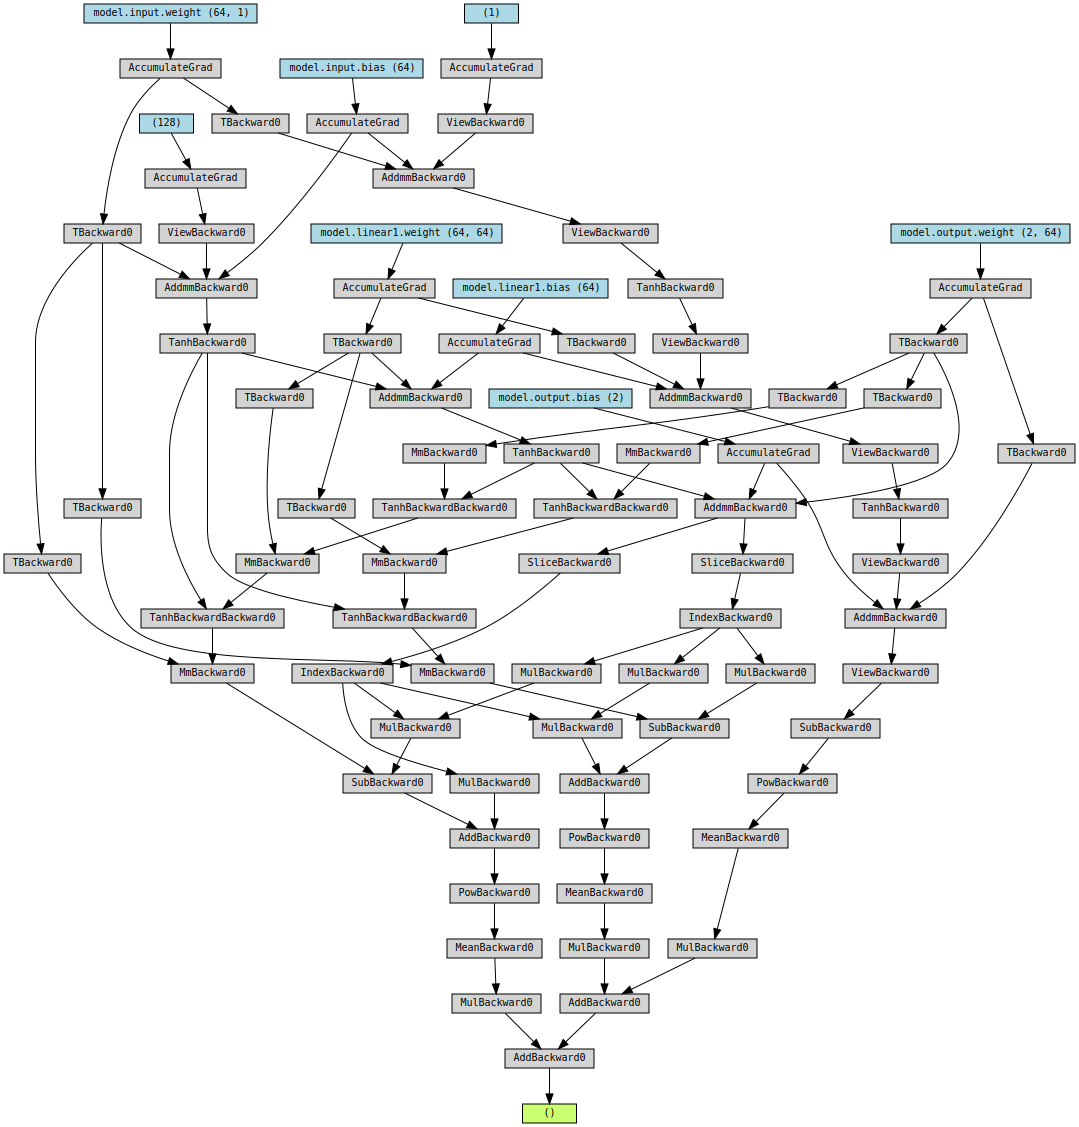

In [10]:
from torchviz import make_dot

make_dot(L, params=dict(model.named_parameters()))

In [19]:
import graphviz

In [22]:
graphviz.Digraph()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [25]:
import graphviz

dot = graphviz.Digraph('round-table', comment='The Round Table') 

In [26]:
dot

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH